# PyTorch를 활용한 다중 클래스 분류: MNIST 데이터셋으로 MLP 모델

이번에는 PyTorch를 사용하여 MNIST 데이터셋으로 다중 클래스 분류(Multiclass Classification) 문제를 해결하는 과정을 단계별로 살펴보도록 하겠습니다.

데이터 로드부터 모델 학습, 평가 및 시각화까지의 전 과정을 포함하며, 모델 성능을 개선하기 위한 과제도 함께 제공합니다.

## 1. 필요한 라이브러리 import 및 설정

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# GPU 사용 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 재현성을 위한 시드 설정
torch.manual_seed(42)

Using device: cpu


## 2. 데이터 준비 및 탐색

- MNIST 데이터셋을 다운로드하고 DataLoader를 사용하여 배치 처리를 준비합니다. 데이터셋의 특성을 탐색하여 이해를 돕습니다.

In [ ]:
# 데이터 변환 정의
transform = transforms.ToTensor()

# 데이터셋 다운로드
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader 생성
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Train dataset size: 60000
Test dataset size: 10000


### ToTensor 변환의 역할

1. PyTorch Tensor로 변환: 데이터를 모델에서 처리할 수 있는 텐서 형태로 변환.
2. 차원 변경: 이미지 데이터의 차원을 (H, W, C)에서 (C, H, W)로 변경.
3. 정규화: 픽셀 값을 0에서 255 범위의 정수에서 0에서 1 범위의 실수로 정규화.

### DataLoader

- 배치 처리를 위한 데이터 로더 생성

### 데이터셋 탐색

Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Class to index mapping: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
Data shape: torch.Size([60000, 28, 28])
Targets shape: torch.Size([60000])


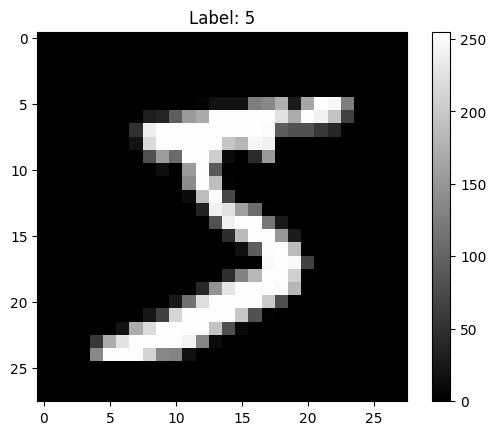

Batch shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


In [ ]:
# 데이터셋 탐색
print("Classes:", train_dataset.classes)
print("Class to index mapping:", train_dataset.class_to_idx)
print("Data shape:", train_dataset.data.shape)
print("Targets shape:", train_dataset.targets.shape)

# 첫 번째 이미지 시각화
plt.imshow(train_dataset.data[0], cmap="gray")
plt.colorbar()
plt.title(f"Label: {train_dataset.targets[0]}")
plt.show()

# DataLoader를 통한 배치 데이터 확인
x_batch, y_batch = next(iter(train_loader))
print("Batch shape:", x_batch.shape)
print("Batch labels shape:", y_batch.shape)

### 데이터 시각화

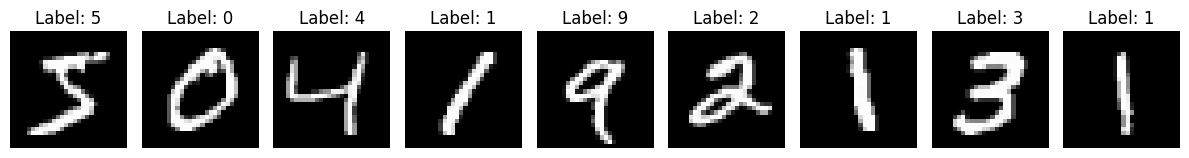

In [ ]:
def show_sample(dataset, num_samples=9):
    fig, axes = plt.subplots(1, num_samples, figsize=(12, 3))
    for i in range(num_samples):
        img, label = dataset[i]
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

show_sample(train_dataset)

- show_sample 함수

    - 데이터셋에서 샘플 이미지를 시각화하여 데이터의 분포와 품질을 확인.

- 첫 번째 이미지 시각화

    - 데이터셋의 첫 번째 이미지를 확인하여 레이블과 이미지의 일치를 검증.

## 3. 모델 정의

간단한 다층 퍼셉트론(MLP) 모델을 정의합니다.

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

model = MLP().to(DEVICE)
print(model)

# flatten 동작 확인
x_batch, _ = next(iter(train_loader))
print("Original shape:", x_batch.shape)
print("Flattened shape:", torch.flatten(x_batch, start_dim=1).shape)

MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
Original shape: torch.Size([64, 1, 28, 28])
Flattened shape: torch.Size([64, 784])


- Flatten 레이어: 입력 이미지를 1차원 벡터로 변환 (batch_size, 1, 28, 28) → (batch_size, 784).

- Linear 레이어:
    - 첫 번째 Linear(28*28, 100): 입력 784차원 → 100차원.
    - ReLU 활성화 함수: 비선형성 추가.
    - 두 번째 Linear(100, 10): 100차원 → 10차원 (클래스 수).

## 4. Cross Entropy Loss 이해하기

Cross Entropy Loss가 왜 모델에 Softmax를 포함하지 않아도 되는지 살펴봅니다.

In [ ]:
def cross_entropy_example():
    # 임의의 모델 출력과 레이블 생성
    y_hat = torch.randn(3, 5)  # 3개 샘플, 5개 클래스
    y_batch = torch.randint(5, (3,))

    print("Model output (logits):")
    print(y_hat)
    print("\nTrue labels:", y_batch)

    # 1. F.cross_entropy 사용
    loss1 = F.cross_entropy(y_hat, y_batch)
    print("\n1. F.cross_entropy loss:", loss1.item())

    # 2. nn.CrossEntropyLoss 사용
    criterion = nn.CrossEntropyLoss()
    loss2 = criterion(y_hat, y_batch)
    print("2. nn.CrossEntropyLoss:", loss2.item())

    # 3. 수동으로 계산
    y_hat_soft = F.softmax(y_hat, dim=1)
    loss3 = 0
    for i, prob in enumerate(y_hat_soft):
        loss3 += -torch.log(prob[y_batch[i]])
    loss3 /= len(y_batch)
    print("3. Manual calculation:", loss3.item())

cross_entropy_example()

Model output (logits):
tensor([[ 1.6340, -0.3358, -0.0257, -0.8888, -0.0637],
        [-0.3118, -0.6689,  0.0149,  1.1755, -0.3993],
        [ 1.3202,  0.5494,  0.8071,  0.0600,  0.6441]])

True labels: tensor([4, 1, 4])

1. F.cross_entropy loss: 2.125499963760376
2. nn.CrossEntropyLoss: 2.125499963760376
3. Manual calculation: 2.125499963760376


- Cross Entropy Loss와 Softmax

    - F.cross_entropy 및 nn.CrossEntropyLoss는 내부적으로 Softmax를 포함.
    - 따라서 모델 출력에 별도의 Softmax를 적용할 필요 없음.

- 수동 계산
    
    - Softmax를 먼저 적용한 후 로그를 취해 Cross Entropy를 계산. 이는 F.cross_entropy의 동작과 동일함을 확인.

## 5. 학습 함수 정의

모델을 학습시키기 위한 함수를 정의합니다.



In [ ]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

- 모델 학습 모드 설정

    - model.train()을 통해 드롭아웃 등 학습 전용 레이어 활성화.

- 순전파 및 역전파

    - optimizer.zero_grad(): 이전 기울기 초기화.
    - outputs = model(inputs): 모델을 통해 예측값 계산.
    - loss = criterion(outputs, labels): 손실 계산.
    - loss.backward(): 기울기 계산.
    - optimizer.step(): 파라미터 업데이트.

- 정확도 계산: 예측값과 실제 레이블의 일치 여부를 통해 정확도 산출.

## 6. 평가 함수 정의
모델의 성능을 평가하기 위한 함수를 정의합니다.

In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

- 모델 평가 모드 설정: model.eval()을 통해 드롭아웃 등 평가 전용 레이어 비활성화.
- 기울기 계산 비활성화: torch.no_grad()로 메모리 절약 및 계산 속도 향상.
- 손실 및 정확도 계산: 학습 함수와 동일한 방식으로 손실과 정확도 산출.

## 7. 모델 학습

모델을 학습시키고, 학습 과정과 결과를 시각화합니다.

In [ ]:
EPOCHS = 5
LR = 1e-3

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

train_losses, train_accs = [], []
test_losses, test_accs = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, DEVICE)
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print("-"*50)

Epoch 1/5:
Train Loss: 2.2007, Train Acc: 34.09%
Test Loss: 2.0926, Test Acc: 53.26%
--------------------------------------------------
Epoch 2/5:
Train Loss: 1.9733, Train Acc: 64.27%
Test Loss: 1.8240, Test Acc: 70.65%
--------------------------------------------------
Epoch 3/5:
Train Loss: 1.6824, Train Acc: 73.16%
Test Loss: 1.5124, Test Acc: 74.98%
--------------------------------------------------
Epoch 4/5:
Train Loss: 1.3848, Train Acc: 76.02%
Test Loss: 1.2301, Test Acc: 78.49%
--------------------------------------------------
Epoch 5/5:
Train Loss: 1.1388, Train Acc: 79.06%
Test Loss: 1.0159, Test Acc: 81.12%
--------------------------------------------------


- 하이퍼파라미터 설정

    - EPOCHS = 5: 전체 데이터셋을 5번 반복하여 학습.
    - LR = 1e-3: 학습률 설정.

- 손실 함수 및 옵티마이저

    - criterion = nn.CrossEntropyLoss(): 다중 클래스 분류에 적합한 손실 함수.
    - optimizer = optim.SGD: SGD 옵티마이저 사용.

- 학습 루프
    - 각 에포크마다 학습 및 평가 수행.
    - 손실 및 정확도 기록.
    - 학습 진행 상황 출력.

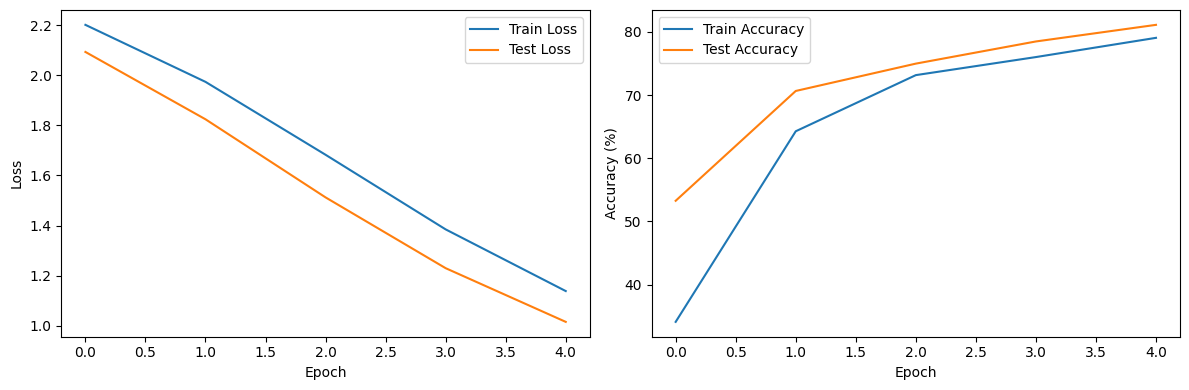

In [ ]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

- 학습 결과 시각화

    - 손실 및 정확도 변화를 그래프로 시각화하여 학습 과정 확인.

## 8. 모델 저장 및 로드
학습된 모델을 저장하고, 필요 시 로드하여 사용할 수 있습니다.

In [ ]:
# 모델 저장
torch.save(model.state_dict(), 'mnist_mlp.pth')

# 모델 로드
loaded_model = MLP().to(DEVICE)
loaded_model.load_state_dict(torch.load('mnist_mlp.pth'))

<ipython-input-11-3609173c5b56>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load('mnist_mlp.pth'))


<All keys matched successfully>

- torch.save: 모델의 상태(dict)를 파일로 저장.
- torch.load: 저장된 상태를 로드하여 새로운 모델 인스턴스에 적용.


## 9. 예측 결과 시각화

모델의 예측 결과를 시각화하여 실제 레이블과의 일치를 확인합니다.

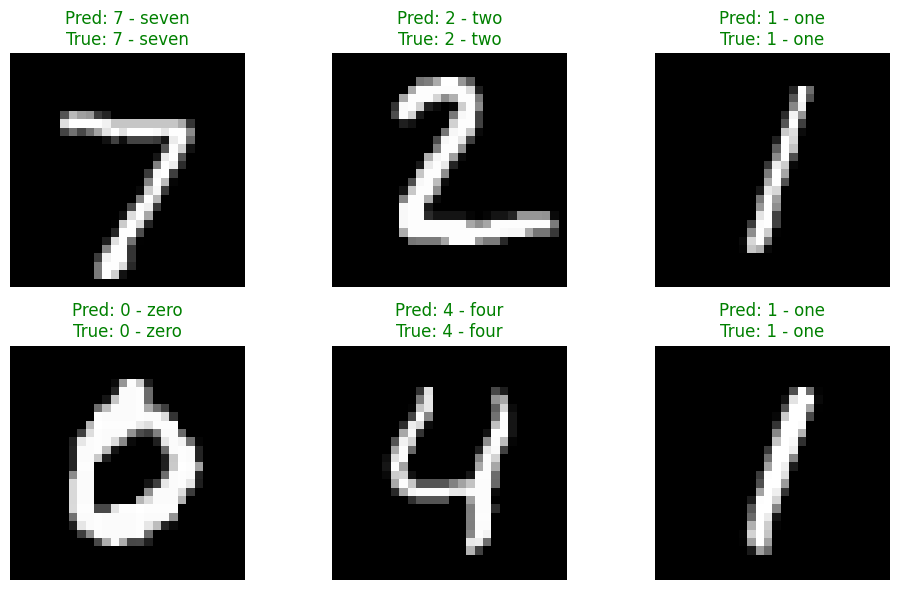

In [ ]:
def visualize_predictions(model, test_loader, device, num_samples=6):
    model.eval()
    images, labels = next(iter(test_loader))
    images, labels = images[:num_samples].to(device), labels[:num_samples].to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = outputs.max(1)

    fig, axes = plt.subplots(2, 3, figsize=(10, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].cpu().squeeze(), cmap='gray')
        pred_class = test_loader.dataset.classes[predicted[i]]
        true_class = test_loader.dataset.classes[labels[i]]
        ax.set_title(f"Pred: {pred_class}\nTrue: {true_class}", color="green" if pred_class == true_class else "red")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_predictions(loaded_model, test_loader, DEVICE)

- 시각화 함수: 지정된 수의 샘플에 대해 예측 결과와 실제 레이블을 시각적으로 표시.
- 정확도 색상 표시: 예측이 정확하면 제목을 초록색, 아니면 빨간색으로 표시하여 한눈에 확인 가능.

## 10. 모델 파라미터 수 계산

모델의 학습 가능한 파라미터 수를 계산하여 모델의 복잡성을 파악합니다.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total trainable parameters: {count_parameters(model)}")

Total trainable parameters: 79510


- 파라미터 수 계산: 모델의 모든 학습 가능한 파라미터 수를 합산하여 출력.
- 모델 복잡성 파악: 파라미터 수가 많을수록 모델의 복잡성이 높아지며, 학습에 필요한 데이터와 계산량도 증가.

## 11. 과제: 모델 성능 개선하기

현재 80% 정도의 성능을 보여주는 것을 보면 준수하다고 볼 수도 있지만, 여러분들의 아이디어를 활용해서 성능을 개선 시켜 보세요.

1. 학습률 (Learning Rate) 조정

    - 현재 학습률 lr=1e-3을 변경하여 모델의 학습 속도와 성능을 관찰해 보세요.
    - 예시, 더 높은 학습률(lr=1e-2)이나 더 낮은 학습률(lr=1e-4)을 시도해 보세요.

2. 에포크 수 증가

    - 현재 에포크 수 EPOCHS=5를 늘려 모델이 충분히 학습할 수 있도록 해보세요.
    - 예를 들어, EPOCHS=20 또는 EPOCHS=50으로 설정하고 학습 과정을 관찰하세요.

3. 모델 구조 변경

    - 단일 히든 레이어 대신 다층 신경망(Multi-layer Neural Network)을 구성하여 모델의 표현력을 높여보세요.

    ```
    class ImprovedMLP(nn.Module):
        def __init__(self):
            super().__init__()
            self.flatten = nn.Flatten()
            self.linear = nn.Sequential(
                nn.Linear(28*28, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Linear(128, 10)
            )

        def forward(self, x):
            x = self.flatten(x)
            return self.linear(x)
    ```

4. 손실 함수 및 옵티마이저 변경

    - nn.CrossEntropyLoss 대신 nn.NLLLoss를 사용해 보세요. 이 경우 출력에 log_softmax를 적용해야 합니다.
    
    - 옵티마이저를 A 또는 RMSprop으로 변경하여 학습 속도와 성능을 비교해 보세요.

    ```
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    ```

5. 데이터 정규화 (Normalization)

    - 특징 데이터의 스케일을 조정하여 모델 학습을 용이하게 만들어보세요.

    ```
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    ```

6. 정규화 기법 적용

    - 과적합을 방지하기 위해 드롭아웃(Dropout)이나 배치 정규화(Batch Normalization)를 적용해 보세요.

        ```
        class ImprovedMLP(nn.Module):
            def __init__(self):
                super().__init__()
                self.flatten = nn.Flatten()
                self.linear = nn.Sequential(
                    nn.Linear(28*28, 256),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(256, 128),
                    nn.ReLU(),
                    nn.Dropout(0.2),
                    nn.Linear(128, 10)
                )

            def forward(self, x):
                x = self.flatten(x)
                return self.linear(x)
        ```

7. 데이터 증강 기법 적용

    - 이미지 회전, 이동 등 데이터 증강을 통해 데이터 다양성을 높이고 모델의 일반화 성능을 향상시켜 보세요.

    ```
    transform = transforms.Compose([
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    ```

    - 다만, 데이터 증강 과정에서 시간이 많이 소요 될 수도 있으니 참고해주세요.

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# GPU 사용 설정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# 재현성을 위한 시드 설정
torch.manual_seed(42)

# 데이터 변환 정의
transform = transforms.ToTensor()

Using device: cuda


In [2]:
# # 데이터셋 다운로드
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader 생성
BATCH_SIZE = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 351kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.10MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.40MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Train dataset size: 60000
Test dataset size: 10000


Classes: ['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
Class to index mapping: {'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}
Data shape: torch.Size([60000, 28, 28])
Targets shape: torch.Size([60000])


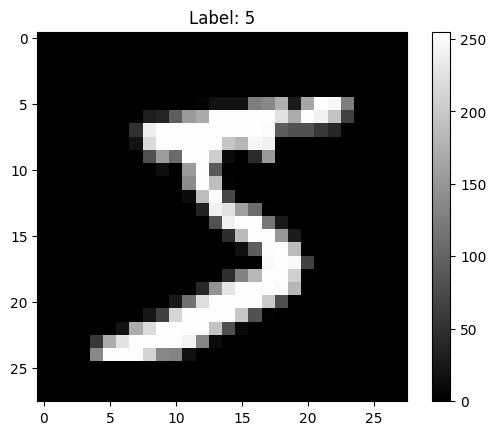

Batch shape: torch.Size([64, 1, 28, 28])
Batch labels shape: torch.Size([64])


In [3]:
# 데이터셋 탐색
print("Classes:", train_dataset.classes)
print("Class to index mapping:", train_dataset.class_to_idx)
print("Data shape:", train_dataset.data.shape)
print("Targets shape:", train_dataset.targets.shape)

# 첫 번째 이미지 시각화
plt.imshow(train_dataset.data[0], cmap="gray")
plt.colorbar()
plt.title(f"Label: {train_dataset.targets[0]}")
plt.show()

# DataLoader를 통한 배치 데이터 확인
x_batch, y_batch = next(iter(train_loader))
print("Batch shape:", x_batch.shape)
print("Batch labels shape:", y_batch.shape)

In [9]:
class MnistClassification(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(28*28, 392),
            nn.BatchNorm1d(392),
            nn.ReLU(),
            nn.Linear(392, 196),
            nn.BatchNorm1d(196),
            nn.ReLU(),
            nn.Linear(196, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.linear(x)

model = MnistClassification().to(DEVICE)
print(model)

# flatten 동작 확인
x_batch, _ = next(iter(train_loader))
print("Original shape:", x_batch.shape)
print("Flattened shape:", torch.flatten(x_batch, start_dim=1).shape)

MnistClassification(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): BatchNorm1d(392, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=392, out_features=196, bias=True)
    (4): BatchNorm1d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=196, out_features=100, bias=True)
    (7): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Linear(in_features=100, out_features=10, bias=True)
  )
)
Original shape: torch.Size([64, 1, 28, 28])
Flattened shape: torch.Size([64, 784])


In [10]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()



        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [11]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

In [12]:
model = MnistClassification().to(DEVICE)

EPOCHS = 20
LR = 1e-2

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                  factor=0.1, patience=10)

train_losses, train_accs = [], []
test_losses, test_accs = [], []
pre_lr = optimizer.param_groups[0]['lr']

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, DEVICE)
    test_loss, test_acc = evaluate(model, test_loader, criterion, DEVICE)

    scheduler.step(train_loss)
    if optimizer.param_groups[0]['lr'] != pre_lr :
        print(f"Learning Rate {pre_lr} -> {optimizer.param_groups[0]['lr']}")
    pre_lr = optimizer.param_groups[0]['lr']

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print("-"*50)

Epoch 1/20:
Train Loss: 0.2189, Train Acc: 93.43%
Test Loss: 0.1195, Test Acc: 96.50%
--------------------------------------------------
Epoch 2/20:
Train Loss: 0.1103, Train Acc: 96.58%
Test Loss: 0.0854, Test Acc: 97.28%
--------------------------------------------------
Epoch 3/20:
Train Loss: 0.0801, Train Acc: 97.50%
Test Loss: 0.0799, Test Acc: 97.55%
--------------------------------------------------
Epoch 4/20:
Train Loss: 0.0684, Train Acc: 97.87%
Test Loss: 0.0711, Test Acc: 97.90%
--------------------------------------------------
Epoch 5/20:
Train Loss: 0.0577, Train Acc: 98.19%
Test Loss: 0.0627, Test Acc: 98.03%
--------------------------------------------------
Epoch 6/20:
Train Loss: 0.0508, Train Acc: 98.28%
Test Loss: 0.0686, Test Acc: 97.90%
--------------------------------------------------
Epoch 7/20:
Train Loss: 0.0458, Train Acc: 98.55%
Test Loss: 0.0626, Test Acc: 98.14%
--------------------------------------------------
Epoch 8/20:
Train Loss: 0.0397, Train Acc

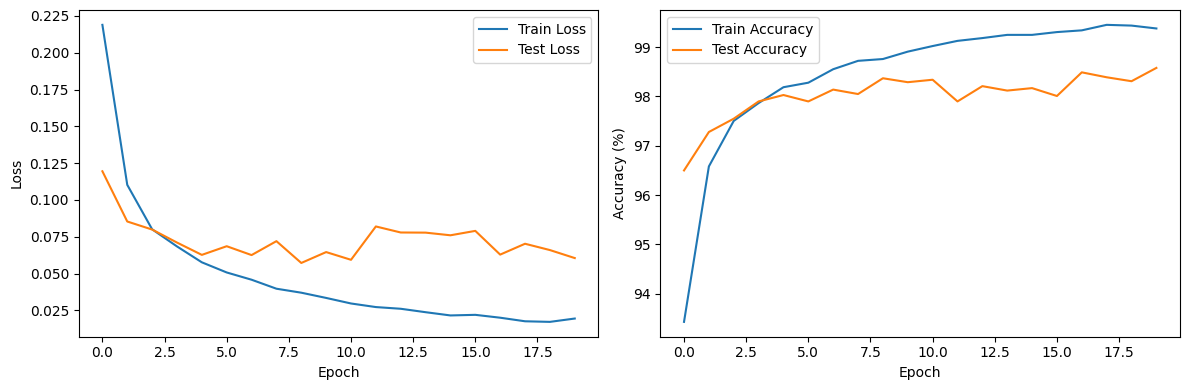

In [13]:
# 학습 결과 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(test_accs, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 12. 결론

이번에는 PyTorch를 사용하여 MNIST 데이터셋으로 다중 클래스 분류 모델을 구축하고 평가하는 과정을 학습했습니다. 주요 학습 내용은 다음과 같습니다.

1. MNIST 데이터셋 로딩, 전처리 및 탐색
2. 간단한 MLP 모델 구현
3. Cross Entropy Loss의 이해
4. 모델 학습 및 평가 과정
5. 학습 결과 시각화
6. 모델 저장 및 로드
7. 예측 결과 시각화
8. 모델 파라미터 수 계산

이 기본적인 구현을 바탕으로, 다음과 같은 추가 실험을 통해 모델의 성능을 더욱 개선하고 딥러닝 모델의 동작 원리를 깊이 이해할 수 있으셨을 겁니다.

1. 모델 아키텍처 변경 (더 깊은 네트워크, CNN 사용 등)
2. 하이퍼파라미터 튜닝 (학습률, 배치 크기, 에포크 수 등)
3. 데이터 증강 기법 적용
4. 정규화 기법 적용 (Dropout, BatchNorm 등)
5. 다른 최적화 알고리즘 시도 (SGD, RMSprop 등)

이를 통해 딥러닝 모델의 다양한 측면을 탐구해보시고, 추후에 성능 개선을 위한 수단으로 적용해주세요.